<a href="https://colab.research.google.com/github/anujsaxena/AIML/blob/main/AIML_19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Density-based spatial clustering of applications with noise(DBSCAN)**
Clustering algorithm

class sklearn.cluster.DBSCAN(eps=0.5, *, min_samples=5, metric='euclidean', metric_params=None, algorithm='auto', leaf_size=30, p=None, n_jobs=None

https://scikit-learn.org/stable/modules/generated/sklearn.cluster.DBSCAN.html

eps: specifies how close points should be to each other to be considered a part of a cluster. It means that if the distance between two points is lower or equal to this value (eps), these points are considered neighbors.

minPoints: the minimum number of points to form a dense region. For example, if we set the minPoints parameter as 5, then we need at least 5 points to form a dense region.

In [ ]:
from sklearn.cluster import DBSCAN
import numpy as np
X = np.array([[1,1], [2,2], [2,3],[8,7], [8,8], [25,80]])
clust =  DBSCAN(eps=0.5, min_samples=2)
mod = clust.fit(X)


In [ ]:
print(mod)

DBSCAN(min_samples=2)


In [ ]:
print(mod.labels_)

[-1 -1 -1 -1 -1 -1]


In [ ]:
X = np.array([[1,1], [2,2], [2,3],[8,7], [8,8], [25,80]])
clust =  DBSCAN(eps=3, min_samples=2)
mod = clust.fit(X)
print(mod)
print(mod.labels_)

DBSCAN(eps=3, min_samples=2)
[ 0  0  0  1  1 -1]


In [ ]:
X = np.array([[1,2], [2,1], [2,3],[8,7], [7,8], [8,9]])
clust =  DBSCAN(eps=3, min_samples=2)
mod = clust.fit(X)
print(mod)
print(mod.labels_)

DBSCAN(eps=3, min_samples=2)
[0 0 0 1 1 1]


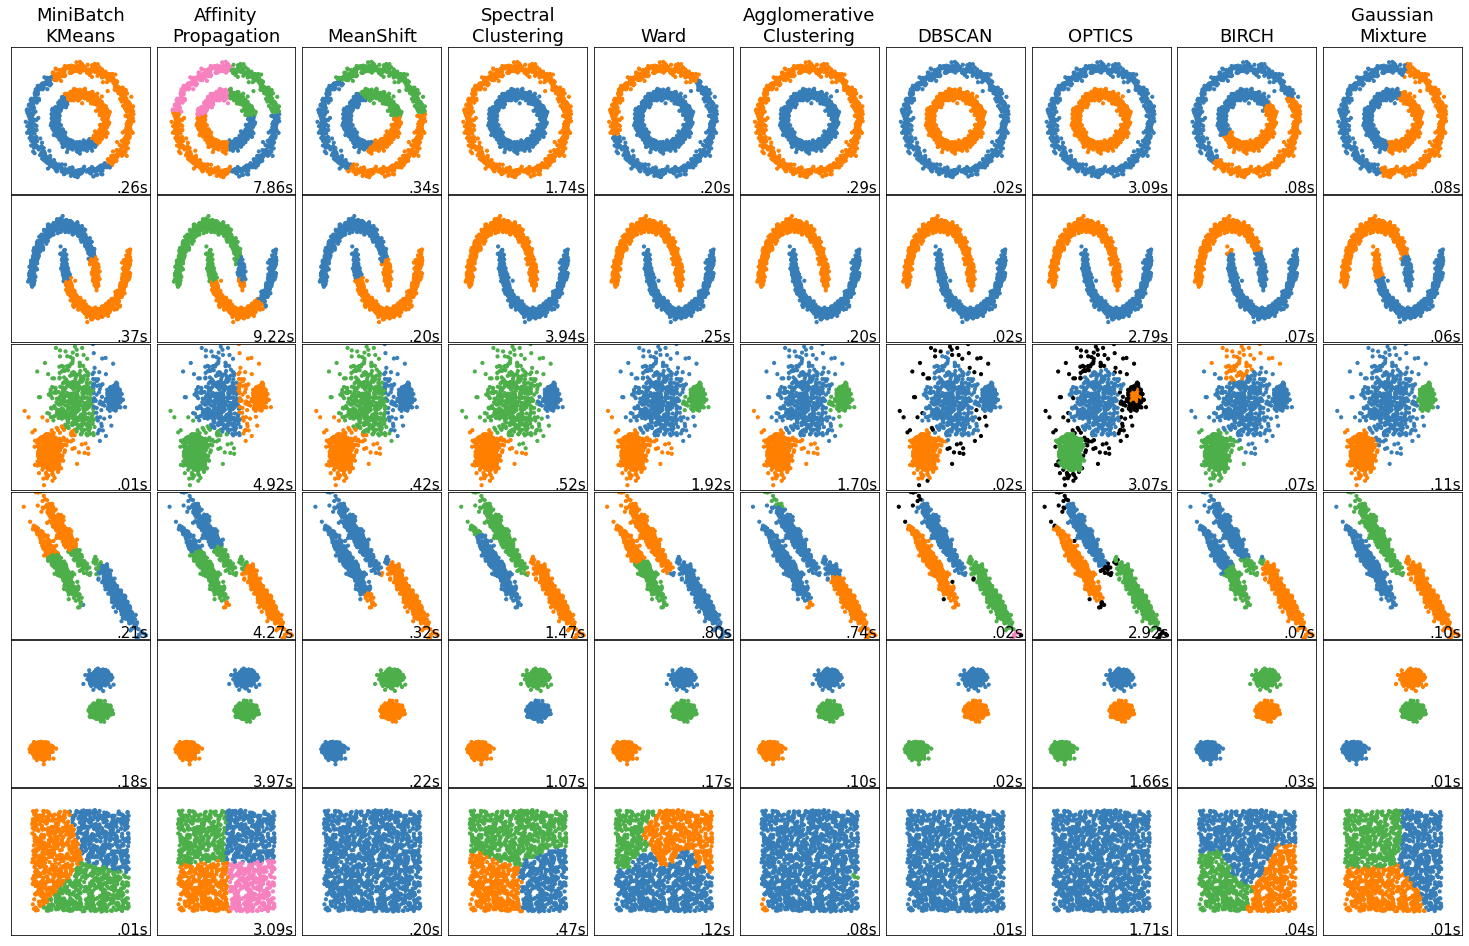

In [ ]:
import time
import warnings
import numpy as np
import matplotlib.pyplot as plt
from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

np.random.seed(0)
n_samples= 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state)

# ============
# Set up cluster parameters
# ============
plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01)

plot_num = 1

default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}


datasets = [
    (
        noisy_circles,
        {
            "damping": 0.77,
            "preference": -240,
            "quantile": 0.2,
            "n_clusters": 2,
            "min_samples": 20,
            "xi": 0.25,
        },
    ),
    (noisy_moons, {"damping": 0.75, "preference": -220, "n_clusters": 2}),
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
    (
        aniso,
        {
            "eps": 0.15,
            "n_neighbors": 2,
            "min_samples": 20,
            "xi": 0.1,
            "min_cluster_size": 0.2,
        },
    ),
    (blobs, {}),
    (no_structure, {}),
]

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(X, n_neighbors=params["n_neighbors"], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        plot_num += 1

plt.show()



In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
  
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA

X = pd.read_csv('CC_GENERAL.csv')
X = X.drop('CUST_ID', axis=1)
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
X.fillna(method ='ffill', inplace = True)
X.head()

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,627.284787,0.000000,12
4,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [ ]:
sc = StandardScaler()
X_sc = sc.fit_transform(X)
X_nm = normalize(X_sc)
df = pd.DataFrame(X_nm)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,-0.312038,-0.106331,-0.181129,-0.152156,-0.148808,-0.198985,-0.343796,-0.289304,-0.301518,-0.287892,-0.202942,-0.217975,-0.409413,-0.225497,-0.130160,-0.224036,0.153753
1,0.219928,0.037539,-0.131224,-0.099751,-0.127038,0.728177,-0.341439,-0.189662,-0.256269,0.160403,0.030762,-0.165387,0.192455,0.228782,0.024353,0.065458,0.100798
2,0.126684,0.146785,-0.030505,0.030851,-0.128792,-0.132251,0.359775,0.757449,-0.259805,-0.191342,-0.134881,-0.030888,0.234046,-0.108741,-0.028363,-0.148900,0.102189
3,0.020571,-0.426063,0.097223,0.228832,-0.190449,-0.154451,-0.424878,-0.167299,-0.384185,-0.108474,-0.138062,-0.231084,0.346093,-0.250827,-0.041942,-0.220185,0.151110
4,-0.151630,0.218959,-0.195282,-0.146778,-0.192118,-0.197278,-0.428601,-0.168765,-0.387551,-0.285424,-0.201202,-0.233109,-0.382671,-0.153993,-0.110323,-0.222114,0.152435


In [ ]:
pca = PCA(n_components = 2)
X_pca = pca.fit_transform(df)
X_pca = pd.DataFrame(X_pca)
X_pca.columns = ['P1', 'P2']
print(X_pca.head())

         P1        P2
0 -0.489949 -0.679976
1 -0.519099  0.544828
2  0.330634  0.268878
3 -0.481657 -0.097608
4 -0.563512 -0.482506


In [ ]:
db_df = DBSCAN(eps = 0.0375, min_samples = 3)
mod = db_df.fit(X_pca)
labels = mod.labels_
labels

array([0, 0, 0, ..., 0, 0, 0])

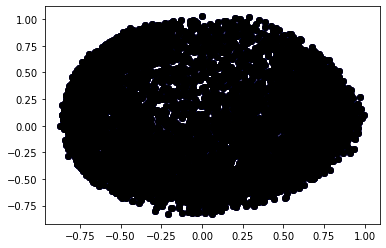

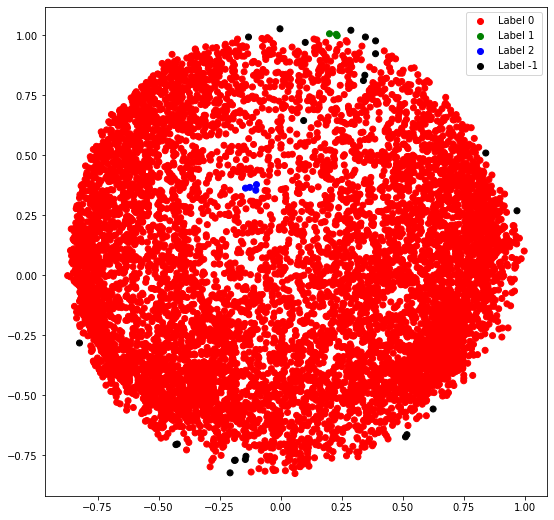

In [ ]:
# Building the label to colour mapping
colours = {}
colours[0] = 'r'
colours[1] = 'g'
colours[2] = 'b'
colours[-1] = 'k'
  
# Building the colour vector for each data point
cvec = [colours[label] for label in labels]
  
# For the construction of the legend of the plot
r = plt.scatter(X_pca['P1'], X_pca['P2'], color ='r');
g = plt.scatter(X_pca['P1'], X_pca['P2'], color ='g');
b = plt.scatter(X_pca['P1'], X_pca['P2'], color ='b');
k = plt.scatter(X_pca['P1'], X_pca['P2'], color ='k');
  
# Plotting P1 on the X-Axis and P2 on the Y-Axis 
# according to the colour vector defined
plt.figure(figsize =(9, 9))
plt.scatter(X_pca['P1'], X_pca['P2'], c = cvec)
  
# Building the legend
plt.legend((r, g, b, k), ('Label 0', 'Label 1', 'Label 2', 'Label -1'))
  
plt.show()

In [ ]:
db = DBSCAN(eps = 0.0375, min_samples = 50).fit(X_pca)
labels1 = db.labels_

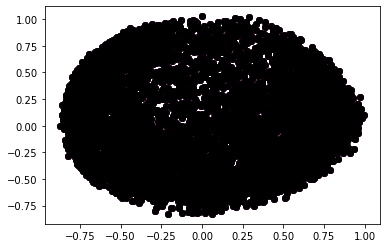

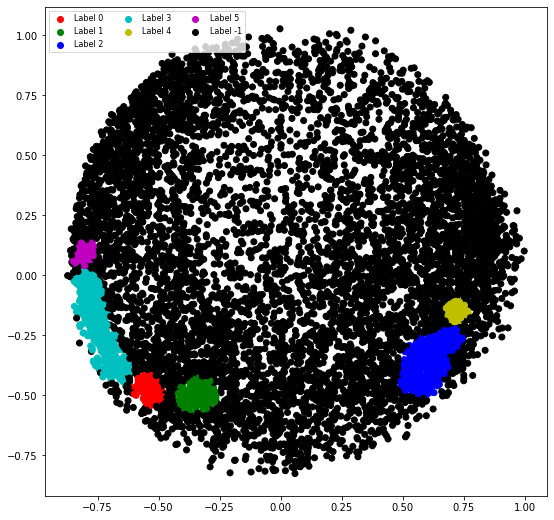

In [24]:
colours1 = {}
colours1[0] = 'r'
colours1[1] = 'g'
colours1[2] = 'b'
colours1[3] = 'c'
colours1[4] = 'y'
colours1[5] = 'm'
colours1[-1] = 'k'
  
cvec = [colours1[label] for label in labels1]
colors = ['r', 'g', 'b', 'c', 'y', 'm', 'k' ]
  
r = plt.scatter(
        X_pca['P1'], X_pca['P2'], marker ='o', color = colors[0])
g = plt.scatter(
        X_pca['P1'], X_pca['P2'], marker ='o', color = colors[1])
b = plt.scatter(
        X_pca['P1'], X_pca['P2'], marker ='o', color = colors[2])
c = plt.scatter(
        X_pca['P1'], X_pca['P2'], marker ='o', color = colors[3])
y = plt.scatter(
        X_pca['P1'], X_pca['P2'], marker ='o', color = colors[4])
m = plt.scatter(
        X_pca['P1'], X_pca['P2'], marker ='o', color = colors[5])
k = plt.scatter(
        X_pca['P1'], X_pca['P2'], marker ='o', color = colors[6])
  
plt.figure(figsize =(9, 9))
plt.scatter(X_pca['P1'], X_pca['P2'], c = cvec)
plt.legend((r, g, b, c, y, m, k),
           ('Label 0', 'Label 1', 'Label 2', 'Label 3', 'Label 4','Label 5', 'Label -1'),
           scatterpoints = 1,
           loc ='upper left',
           ncol = 3,
           fontsize = 8)
plt.show()